# Deep Policy Gradients

## Introduction

### Policy Gradient Reminder

As we've seen in tutorial 4, policy gradients are a Reinforcement Learning technique in which we use some parameterized vector $\theta$ to parametrize our optimal policy. We learn the optimal $\theta$ in the following manner:
1. Define a policy function $\pi(a|\theta,s)$ that outputs an action distribution given a state s and a vector of parameters $\theta$.
2. Define some objective function to measure how 'good' our current $\theta$ is, in terms of expected reward.
3. Use current expected reward from collected experiences to assess objective function values, and use gradients of objective function to update parameters $\theta$ (i.e. according to the Reinforce algorithm).

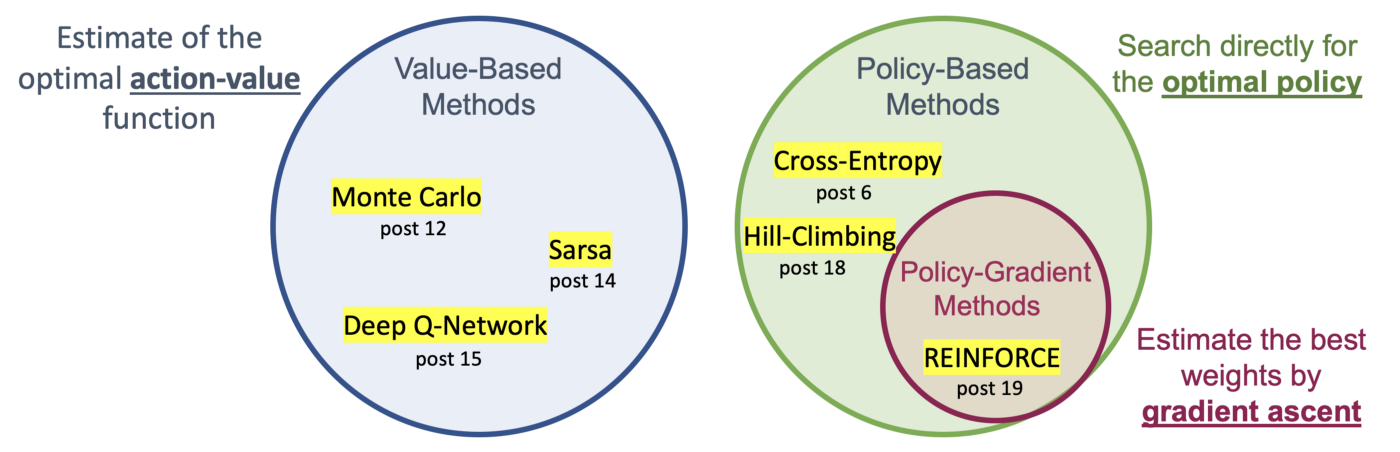

In [1]:
from IPython import display
import stable_baselines3
display.Image("images/overview.png")

source: https://torres.ai

### Deep Policy Gradients

In this tutorial we will introduce a common and powerful way of using the policy gradients technique - Deep Policy Gradients.

When using DPG (Deep Policy Gradients), we specifically use *deep neural networks* to represent our parametrized policy distribution function. Our parameters vector $\theta$ will be our model's weights and biases.

#### Deep Neural Networks Recap

Deep neural networks are essentially a set of functions, called neurons, nested within each other.

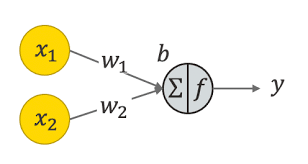

In [2]:
display.Image("images/neuron.png")

source: Katherin Melcher, knime.com

Each neuron is a multivariate function that's usually composed of 3 parts - A weight vector, a bias term (scalar) and an activation function. For any input vector, the neuron takes the inner product of the input with the weights, adds the bias, and then activates the activaion function over the result (which is a scalar).

When putting these neurons together, activating them on after the other over our input, we get a deep neural network.

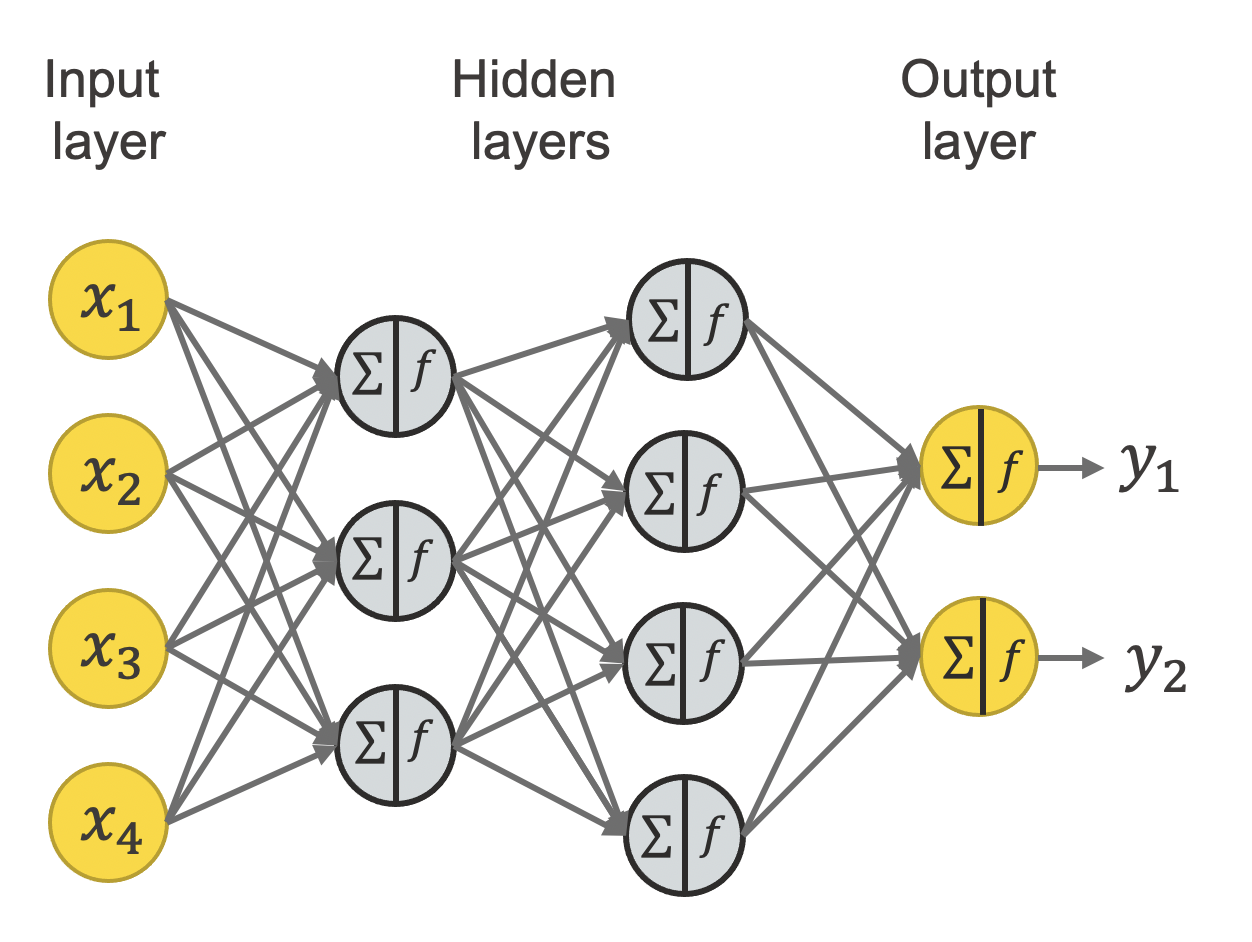

In [4]:
display.Image('images/deepnn.png')

source: Katherin Melcher, knime.com

In *deep learning* we use such a deep model and try to find the best weights and biases so that our model's output would be best, according to some predefined quality measure. For each current given set of learnable parameters (weights and biases) we feed our model the input and calculate the quality of the output. We then differentiate the quality w.r.t the input using the [backpropagation](https://brilliant.org/wiki/backpropagation/) algorithm.

While backproping we update the weights and biases according to the respective gradients along the network. A common way to do so is the *Gradient Descent* algorithm - we change each learnable parameter by a small step (learning rate) in the direction against the one where our gradient is highest, out of hope to move in the steepest direction going down (in loss value).

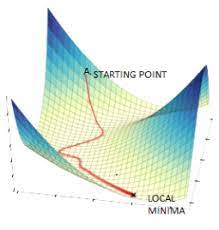

In [5]:
display.Image("images/gd.png")

source: [datasciencecentral.com](datasciencecentral.com)

#### Deep Neural Networks in Policy Gradient Methods

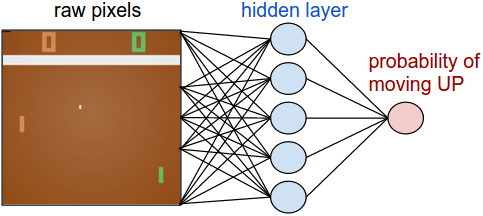

In [6]:
display.Image("images/dpg_illustration.png")

source: theaisummer.com

Our deep model will receive observations from the environment as input, and use current parameters to generate a policy distribution. We'll sample our next action from this distribution, and use the Reinforce algorithm (shown in tutorial 4) to update our weights. We change only the last line (updating $\theta$) so that the value added to $\theta$ is our loss, used to calculate the gradients to update the entire model. See loss explanation ahead. 

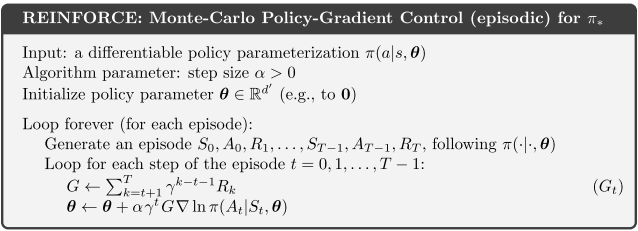

In [7]:
display.Image("images/reinforce.png")

source: datasciencestackexchange.com

## Implementation

First we'll import some needed code and external modules:

In [8]:
'''Deep Learning Tools Imports (Pytorch)'''
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import time

In [9]:
'''Environment Related Imports'''
from pettingzoo.mpe import simple_v2
from multi_taxi import MultiTaxiEnv
from train_and_eval_S import run_episode_single_agent
from dpg_S import DPGAgent
from dpg_S import run_rand
%matplotlib inline

Let's start by Implementing our neural network. A simple single layer model will suffice:

In [10]:
class PolicyNetwork(nn.Module): 
    def __init__(self, learning_rate, input_dims, num_actions, mode,emd_dim = 6):
        super(PolicyNetwork, self).__init__()

        self.input_dims = input_dims #Dimension of model's input vector (i.e. 4 in above model illustration).
        self.learning_rate = learning_rate #The size of algorithm's 'small step' in updating learnable parameters.
        self.num_actions = num_actions #Dimension of model's output (i.e. 2 in above model illustration).
        self.mode = mode #api related setting - pettingzoo or gym.
        self.emb_dim = emd_dim #Preparation for usage of embedding.

        #simple network with one hidden layer, hidden dimension of 8
        h_dim = 8
        self.layers = nn.Sequential(
            nn.Linear(self.input_dims, h_dim), #Holding the Neuron's weights and biases and applies related mathematical function.
            nn.Tanh(), #Activation Function
            nn.Linear(h_dim, self.num_actions),
        )

        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate) #Weights update algorithm.

    def forward(self, observation):
        state = torch.Tensor(observation).to(self.device)
        return self.layers(state)


Next we'll instantiate our agent:
The agent will hold its current policy (deep model), along with the capabilities needed for our algorithm:

1. Sample an action out of the current distribution (save it for objective function evaluation).

2. Gather actions and rewards to evaluate objective function and backprop.

The full implementation is  given in the code files. We'll focus here on the *learn* function - the core of the agent's learning routine:
After running an episode and collecting actions and resulting rewards (according to our current policy distribution), learn calculates the value function G (sum of discounted rewards), log probabilities of our performed actions (out of the current distribution) and uses the inner product to calculate the loss. This is the 'quality function' (mentioned before in the deep learning recap) that our model will use.

* Note: We calculate the value function here only to assess the loss. We *are not learning the value function* - this is a *policy method* based approach.

Note that when using learning models, especially in RL settings, it important to consider reward variance - rewards with high variance could make the model change drastically and often, making learning hard. Deep models are especially sensitive in such cases. 
As countermeasure, here we've used a basic variance reduction technique of subtracting the mean out of all rewards. More complex cases might call for more copmlex methods. 

In [11]:
def learn(self):
    """ Calculate rewards for the episode, compute the gradient of the loss, update optimizer"""
    self.policy.optimizer.zero_grad() #When calculating loss in deep learning, we must first erase previous gradient calculations torch made for us, to avoid unrelated gradient associations.
    G = np.zeros_like(self.reward_mem, dtype=np.float64) 

    for t in range(len(self.reward_mem)): #calculate the value function. G[i] will hold the value of state
        G_sum = 0
        discount = 1

        for k in range(t, len(self.reward_mem)):
            G_sum += self.reward_mem[k] * discount
            discount *= self.gamma
        G[t] = G_sum

    # standardize updates
    mean = np.mean(G)
    std = np.std(G) if np.std(G) > 0 else 1
    G = (G-mean)/std

    G = torch.tensor(G, dtype=torch.float).to(self.policy.device)
    loss = 0

    #use baseline for variance reduction
    baseline = sum(self.reward_mem)/len(self.reward_mem)
    for i in range(len(self.reward_mem)):
        self.reward_mem[i] -= baseline


    for g, logprob in zip(G, self.action_mem): #summate to calculate final loss
        loss += -g*logprob

    loss.backward() #backpropagate
    self.policy.optimizer.step() #update learnable parameters

The core of our training loop would be letting our agent run episodes, collect performed actions and resulting rewards, and then using those with the agent's learn function to update the weights of our learned policy distribution.

In [12]:
def train(env, is_env_multiagent, agents, max_episode_len, num_episodes, display, save_rate, agents_save_path,
        train_result_path):
    if agents_save_path: import dill  # used to save the agents themselves, pickle bad at serializing objecst
    if train_result_path: import pickle

    #we collect all episode experiences to later calculate objective function value
    episode_rewards = [0.0]
    agent_rewards = [[0.0] for _ in range(len(agents))]
    final_ep_rewards = []
    final_ag_ep_rewards = [[] for _ in range(len(agents))]

    episode_step = 1
    train_steps = 0

    print("Starting iterations...")
    t_time = time.time()

    action_list = []
    for i in range(num_episodes):
        #this function runs an episode according to our current policy, and saves all actions performed by the agent and resulting rewards.
        ep_results = run_episode_single_agent(env, agents[0], max_episode_len) 

       
        t_reward, a_rewards, t_steps = ep_results
        train_steps += t_steps

        episode_rewards[-1] += t_reward #we update known rewards for each state and action
        for (idx, a_reward) in enumerate(a_rewards):
            agent_rewards[idx][-1] += a_reward

        for agent in agents:
            agent.episode_callback() #after collecting experiences from episode, this function will call learn and adjust learnable parameters

        if len(episode_rewards) % save_rate == 0: #print data about current progress and current rewards
            final_ep_rewards.append(np.mean(episode_rewards[-save_rate:]))
            for i, rew in enumerate(agent_rewards):
                final_ag_ep_rewards[i].append(np.mean(rew[-save_rate:]))

            print("steps: {}, episodes: {}, mean episode reward:{}, time:{}".format(
                train_steps, len(episode_rewards), final_ep_rewards[-1], time.time() - t_time
            ))

            if agents_save_path:  # if save path provided, save agents to agents_save_path
                with open(agents_save_path, "wb") as fp:
                    pickle.dump(agents, fp)

            if train_result_path:  # if train_result_path provided, save results to train_result_path
                save_obj = dict()

                save_obj["final_ep_rewards"] = final_ep_rewards
                save_obj["final_ag_ep_rewards"] = final_ag_ep_rewards
                save_obj["all_ep_rewards"] = episode_rewards
                save_obj["all_ag_rewards"] = agent_rewards

                with open(train_result_path, "wb") as fp:
                    pickle.dump(save_obj, fp)

            t_time = time.time()

        episode_rewards.append(0)
        for (idx, a_reward) in enumerate(a_rewards):
            agent_rewards[idx].append(0)

        episode_step += 1

    print("Finished a total of {} episodes.".format(len(episode_rewards)))

    if agents_save_path:
        print("Agent saved to {}.".format(agents_save_path))

    if train_result_path:
        # final_ep_rewards, final_ag_rewards, episode_rewards, agent_rewards
        print("Train results saved to {}.".format(train_result_path))

We now have everything we need to setup our environment and our agent and start using DPG:

### Speaker-Listener Environment

In [13]:
#initialize environment
display.Image("images/simple.png")
env = simple_v2.parallel_env(continuous_actions=True)
agent_str = env.possible_agents[0] 
print(f'action space: {env.action_space(agent_str)}')
num_actions = env.action_space(agent_str).shape[0]
print(f'observation space: {env.observation_space(agent_str)}')
num_states = env.observation_space(agent_str).shape[0] 

#instantiate agent 
learning_rate = 0.04
dpg_agent = DPGAgent(learning_rate, num_states, num_actions, gamma=0.99, identifier = 'agent_0', mode='mpe')

action space: Box(0.0, 1.0, (5,), float32)
observation space: Box(-inf, inf, (4,), float32)


We'll run a few episodes of random policy, just to have some visual feeling of how the DPG improves performance.

In [14]:
for i in  range(5):
    run_rand(env)

Now let's train our agent using DPG:

In [15]:
 train(env=env, is_env_multiagent=False, agents=[dpg_agent], max_episode_len=50000, num_episodes=400,
             display=False, save_rate=10, agents_save_path="", train_result_path="")

Starting iterations...


/Users/guyazran/Desktop/School/Master/Teaching/Year 2/Semester B/From Single Agent to Multi-Agent Sequential Decision Making Under Uncertainty/FSTMA-course/tutorials/tut06/dpg_S.py:107: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(self.policy.forward(observation))
/usr/local/Caskroom/miniconda/base/envs/fstma-tut05/lib/python3.8/site-packages/gym/spaces/box.py:153: UserWarning: WARN: Casting input x to numpy array.
  logger.warn("Casting input x to numpy array.")


steps: 250, episodes: 10, mean episode reward:-49.99293391833736, time:0.273205041885376
steps: 500, episodes: 20, mean episode reward:-92.33904436879529, time:0.17772316932678223
steps: 750, episodes: 30, mean episode reward:-61.357967442224684, time:0.1841580867767334
steps: 1000, episodes: 40, mean episode reward:-32.494742878196284, time:0.17316699028015137
steps: 1250, episodes: 50, mean episode reward:-33.55165370181156, time:0.18523812294006348
steps: 1500, episodes: 60, mean episode reward:-33.458891198332125, time:0.1867051124572754
steps: 1750, episodes: 70, mean episode reward:-65.87700869011537, time:0.17821574211120605
steps: 2000, episodes: 80, mean episode reward:-42.02395823747379, time:0.17007112503051758
steps: 2250, episodes: 90, mean episode reward:-78.90406694210677, time:0.1913280487060547
steps: 2500, episodes: 100, mean episode reward:-75.59503395652999, time:0.1862959861755371
steps: 2750, episodes: 110, mean episode reward:-40.570434807997415, time:0.188409090

We'll use a pre-trained model to display training results:

In [16]:
def extract(d):
    return list(d.values())[0]

def run_pretrained(env,model):
    while(True):
    
        observation = env.reset()
        while(True):


            observation = extract(observation)
            # choose and execute action
            with torch.no_grad():
                action = model(observation)
            probs = torch.nn.Softmax(dim=-1)(action)
            observation, reward, done, info = env.step({'agent_0':probs.detach()})
            done = extract(done)
            time.sleep(0.1)

            # stop if done
            if done:
                break

            # render the environment
            env.render()
            
env = simple_v2.parallel_env(continuous_actions=True)
model = PolicyNetwork(0, num_states, num_actions, None)
model.load_state_dict(torch.load('trained_model')) #load trained model
model.eval()
run_pretrained(env,model)

KeyboardInterrupt: 

Here we can also point out the two weaknesses of policy gradients, showcased in tutorial 4 - 

1. Convergence to local minima - we can see that sometimes our agent passes its destination and only then stops, instead of stopping immediately when reaching the destination. slowing down before it.

2. Slow training - the model took about 35000 episodes to train properly (several minutes of training), for a very simple problem with a very thin network. In more complex problems, with more features, who may require deeper and wider neural networks, this might become a major obstacle.

Another noticeable weakness is the difficulty of such models to solve discrete environments. This is explained in detail in the taxi environment section ahead.

### Taxi Environment

In [17]:
'Environment Related Imports'
import gym
from multi_taxi.taxi_environment import TaxiEnv, orig_MAP
from gym import Wrapper
from gym.spaces import MultiDiscrete
from dpg_S import test_continuous_single_agent

In [18]:
'Deep Model Related Imports'
from torch.nn.functional import one_hot
import torch
import numpy as np
from stable_baselines3 import PPO

To easily use the single agent taxi environment with openAI's API, we'll use some environment wrappers (credit to Guy).

This wrapper makes our environment match single taxi settings - i.e. in multi taxi we work with dictionaries holding data for each agent. Here it's unnecessary and we use the wrapper to make the translation.

In [19]:
class SingleTaxiWrapper(Wrapper):
    """
    A wrapper for multi-taxi environments aligning the environments'
    API with OpenAI Gym if using only 1 taxi.
    """
    def __init__(self, env):
        assert env.num_taxis == 1
        super().__init__(env)

    def reset(self):
        # run `reset` as usual.
        # returned value is a dictionary of observations with a single entry
        obs = self.env.reset()
        
        a, b, _, c, d = self.unwrapped.state
        self.unwrapped.state = [a, b, [[0, 0]], c, d]
        

        # return the single entry value as is.
        # no need for the key (only one agent)
        ret = next(iter(obs.values()))
        
        return ret

    def step(self, action):
        # step using "joint action" of a single agnet as a dictionary
        step_rets = self.env.step({self.env.taxis_names[0]: action})

        # unpack step return values from their dictionaries
        return tuple(next(iter(ret.values())) for ret in step_rets)

Same goes for our observations. Especially passengers locations when we only have one passenger.

In [20]:
class SinglePassengerPosWrapper(Wrapper):
    '''Same for above, when we also have only one passenger'''
    def __init__(self, env, taxi_pos):
        super().__init__(env)
        self.__taxi_pos = taxi_pos
    
    def reset(self):
        obs = self.env.reset()
        a, b, _, c, d = self.unwrapped.state
        self.unwrapped.state = [a, b, [[0, 0]], c, d]
        obs[2:4] = self.__taxi_pos
        return obs

An especially important wrapper is the TaxiObsPrepWrapper:
Discrete settings tend to be challenging for deep learning based solutions. Especially when the possible set of values is relatively small. This is partially due to the fact that value differences in such settings might not come to figure in loss differentiation and usage of gradients.
Another problem with discrete settings is scaling our values. Different features (observation fields) may come from different ranges of values. This might make the backpropagation algorithm favor some features over others unjustly.
Let us consider the following example:
Say our taxi move around a grid of 4X1000. This means our locations may look something like [1,2129], [0,10], [3,1], [2,3500] etc.
When dealing with continuous settings, both the X and Y coordinate values still belong to infinite spaces - neither is favoured. 
In discrete settings. however, the Y value space is much larger than the X value space. If our algorithm doesn't learn to distinguish between the two features well enough, it could consider Y corrdinate value changes much more meaningful than changes in X coordinates.

We took two approaches to face these difficulties:

1. We turned the passenger locations from scalars (describing passenger positions) to one hot encoded vectors, so the algorithm could distinguish them better.
2. We scaled the X and Y sizes of the grid before inputing the relevant observations to the model.

In [21]:
class TaxiObsPrepWrapper(Wrapper):
    '''Preprocess observations to make data more meaningful for deep networks - encode passenger locations as vectors
    (one hot) and scale according to coordinate system dimensions.'''
    def __init__(self, env):
        super().__init__(env)
        self.map_h = len(self.unwrapped.desc) - 2 - 1
        self.map_w = (len(self.unwrapped.desc[0]) - 1) // 2 - 1
    
    def reset(self):
        return self._obs_prep(self.env.reset())
    
    def step(self, action):
        obs, r, d, i = self.env.step(action)
        return self._obs_prep(obs), r, d, i
    
    def _obs_prep(self, obs):
        taxi_and_pass = obs[:-self.unwrapped.num_passengers].astype(np.float64)
        pass_stat = obs[-self.unwrapped.num_passengers:]
        
        taxi_and_pass[::2] = taxi_and_pass[::2] / self.map_h
        taxi_and_pass[1::2] = taxi_and_pass[1::2] / self.map_w
        pass_stat = one_hot(torch.from_numpy(pass_stat).to(torch.int64) - 1, num_classes=3).flatten().numpy().astype(np.float64)
        
        return np.concatenate([taxi_and_pass, pass_stat])
    
    @property
    def observation_space(self):
        obs_space_v = self.env.observation_space.nvec
        taxi_pass_info = obs_space_v[:-self.unwrapped.num_passengers]
        new_obs_space_v = np.concatenate([taxi_pass_info,
                                          [2] * (self.unwrapped.num_taxis + 2) * self.unwrapped.num_passengers])
        
        return MultiDiscrete(new_obs_space_v)
        

With these wrappers we can define our environment:

In [22]:
env = TaxiEnv(num_taxis=1, num_passengers=1, pickup_only=True, domain_map=orig_MAP)
env = SingleTaxiWrapper(env)
env = SinglePassengerPosWrapper(env, taxi_pos=[0, 0])
env = TaxiObsPrepWrapper(env)

Now we'll try using DPG to train the model. We'll run the same training regime as before:

In [23]:
test_continuous_single_agent('gym')

Starting iterations...


/Users/guyazran/Desktop/School/Master/Teaching/Year 2/Semester B/From Single Agent to Multi-Agent Sequential Decision Making Under Uncertainty/FSTMA-course/tutorials/tut06/dpg_S.py:123: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(self.policy.forward(observation))


steps: 1547, episodes: 25, mean episode reward:-57.84, time:0.8206048011779785
steps: 3241, episodes: 50, mean episode reward:-67.76, time:0.8670089244842529
steps: 4424, episodes: 75, mean episode reward:-39.24, time:0.6030600070953369
steps: 5845, episodes: 100, mean episode reward:-40.68, time:0.7217190265655518
steps: 7113, episodes: 125, mean episode reward:-46.68, time:0.6571712493896484
steps: 8382, episodes: 150, mean episode reward:-50.76, time:0.643543004989624
steps: 9621, episodes: 175, mean episode reward:-37.44, time:0.6255059242248535
steps: 10837, episodes: 200, mean episode reward:-44.6, time:0.6190409660339355
steps: 12301, episodes: 225, mean episode reward:-50.48, time:0.7355122566223145
steps: 13455, episodes: 250, mean episode reward:-42.12, time:0.5807201862335205
steps: 14615, episodes: 275, mean episode reward:-42.36, time:0.585134744644165
steps: 15846, episodes: 300, mean episode reward:-49.24, time:0.6276311874389648
steps: 16865, episodes: 325, mean episode

We can see the model's having a much harder time converging over this setting.

Due to the above difficulties in using deep neural networks with discrete settings, we couldn't achieve good results for this problem using DPG.
The variance of the results coming from our learned distribution is too high, preventing the the deep model from learning.
Simple variance reduction approaches, such as mean and entropy baselines, also failed in allowing to create an efficient model.
What we've done here instead is using a model called *PPO*.
These are Actor-Critic models (next tutorial), in which we also demand that with each step of updating our weights, we also don't change our policy ditribution "too much".
To measure the change one can use the KL-divergence or various variations of reward expectancy. 
Even though this model gave the best results we could get, results are still relatively unimpressive - the discrete nature of the taxi environment, along with its small feature value ranges, probably made DPG inefficient in this case.

We used the PPO implementations from https://github.com/DLR-RM/stable-baselines3.git

In [24]:
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 155      |
|    ep_rew_mean     | -53.7    |
| time/              |          |
|    fps             | 1445     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 118        |
|    ep_rew_mean          | -17.2      |
| time/                   |            |
|    fps                  | 1127       |
|    iterations           | 2          |
|    time_elapsed         | 3          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.01919364 |
|    clip_fraction        | 0.237      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.6 

Training Results (again using a pre-trained model):

In [27]:
from IPython.display import clear_output
import time
model = PPO.load('trained_taxi.zip')

obs = env.reset()
for i in range(1000):
    action, _state = model.predict(obs, deterministic=False)
    action_str = env.unwrapped.index_action_dictionary[action]
    obs, reward, done, info = env.step(action)
    print(action_str, f'r = {reward}', f'is_done = {done}')
    time.sleep(0.1)
    clear_output(wait=True)
    env.render()
    if done:
        print('done!')
        time.sleep(0.4)
        obs = env.reset()

+---------+
|P: |_: : |
| : | : : |
| : : : : |
| | : | : |
| | : |D: |
+---------+
Taxi0-YELLOW: Fuel: inf, Location: (0,2), Collided: False
Passenger1: Location: (0, 0), Destination: pickup only!
Done: False, {'taxi_0': False, '__all__': False}
Passengers Status's: [2]
west r = -1 is_done = False


KeyboardInterrupt: 